In [18]:
## Mount Drive if needed
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
## CD to directory of choice
# %cd /content/drive/MyDrive/PDL_Final

/content/drive/MyDrive/PDL_Final


# Imports

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from tqdm.notebook import tqdm
import cv2


# Download Dataset

This is the combined dataset of 1549 photos from NIST_SD_18 and 1573 photos from UTKFace dataset.

All photos are grayscale, between the ages of [18, 60] and should have 1495 male and 78 females.

The download also contains a csv file with the metadata in format :
"[ID, Gender, Age, Arrested, Filename]"

In [ ]:
# change "Project_dataset" extension to your own filename
#!wget -O Project_dataset.zip https://www.dropbox.com/scl/fi/41hcdwlwfoi79ag5w3and/all_photos.zip?rlkey=lbo0ij33t62vmcsjli0ng8uap&dl=1
#!unzip Project_dataset.zip

# 1. Data Processing

Dataset should be stored as individual images in a folder, and metadata should be stored in a CSV file with columns: image_name, gender, age, label.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform = False ):
        self.metadata = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.metadata.iloc[idx, 4])
        image = Image.open(img_name).convert('RGB')  # Load as RGB
        image = np.array(image)  # Convert to numpy array for OpenCV

        # Convert to grayscale for contour detection
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Find contours
        edges = cv2.Canny(gray, 50, 150)

        # Convert edges back to PIL Image and grayscale for further processing
        contour_image = Image.fromarray(edges).convert('L')

        gender = self.metadata.iloc[idx, 1]
        age = self.metadata.iloc[idx, 2]
        label = self.metadata.iloc[idx, 3]

        if self.transform:
            contour_image = self.transform(contour_image)

        return contour_image, (gender, age), label

def balance_dataset_by_gender(dataset):
    male_indices = [i for i, (_, (gender, _), _) in enumerate(dataset) if gender == 'male']
    female_indices = [i for i, (_, (gender, _), _) in enumerate(dataset) if gender == 'female']
    num_to_sample = min(len(male_indices), len(female_indices))

    sampled_indices = np.random.choice(male_indices, num_to_sample, replace=False).tolist() + np.random.choice(female_indices, num_to_sample, replace=False).tolist()
    return torch.utils.data.Subset(dataset, sampled_indices)

def filter_dataset_by_age(dataset, age_limit):
    return torch.utils.data.Subset(dataset, [i for i, (_, (_, age), _) in enumerate(dataset) if age <= age_limit])

# Transformations for the images, for example:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

transform_transfer = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert image to 3-channel grayscale
    transforms.Resize((224, 224)),  # Resize to the expected input size for pre-trained networks
    transforms.ToTensor(),
])


In [ ]:
# # change paths according to your directory
# img_dir = "/content/drive/MyDrive/PDL_Final/Datasets/all_photos"
# csv_path = os.path.join(img_dir, "combined_metadata.csv")

Create Datasets

In [ ]:
dataset = CustomDataset(csv_path=csv_path, img_dir=img_dir, transform=transform)
dataset_transfer = CustomDataset(csv_path=csv_path, img_dir=img_dir, transform=transform_transfer)

# Assuming dataset is an instance of CustomDataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Assuming dataset_transfer is an instance of CustomDataset
train_size_transfer = int(0.7 * len(dataset_transfer))
val_size_transfer = int(0.15 * len(dataset_transfer))
test_size_transfer = len(dataset_transfer) - train_size - val_size
train_dataset_transfer, val_dataset_transfer, test_dataset_transfer = random_split(dataset_transfer, [train_size_transfer, val_size_transfer, test_size_transfer])

Plot Examples

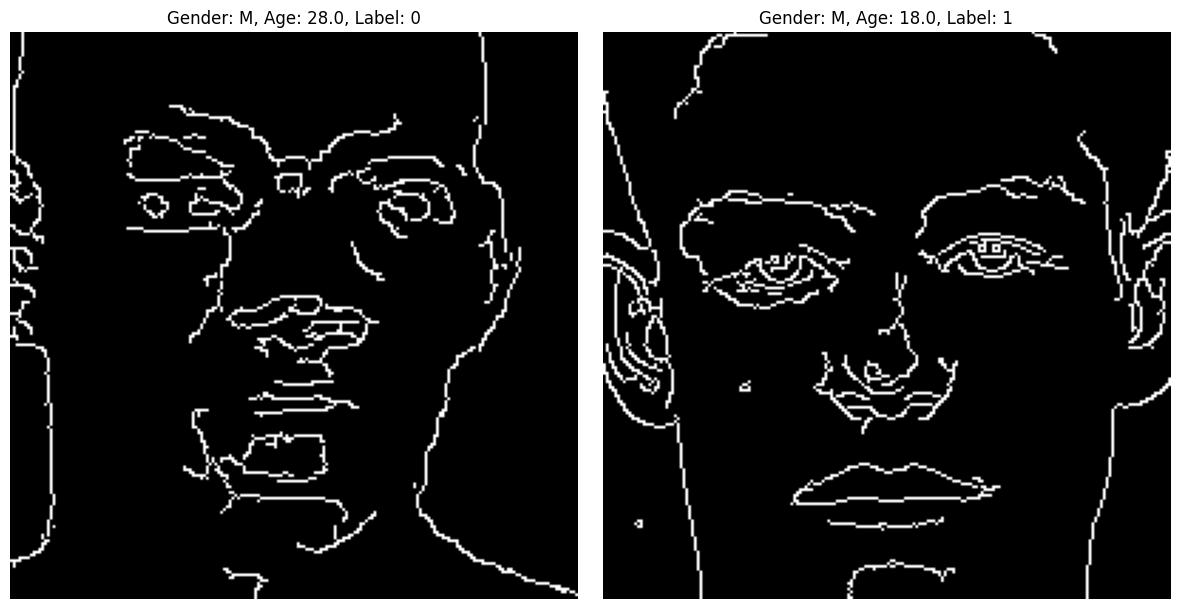

In [ ]:
# Fetch a sample image and its metadata
sample_img_1, (gender_1, age_1), label_1 = dataset[1080]
sample_img_2, (gender_2, age_2), label_2 = dataset[2001]

# Convert the PyTorch tensor to numpy for visualization
# The data comes out in the format (C, H, W) but we need (H, W, C) for visualization, hence the transpose
sample_img_np_1 = sample_img_1.numpy().transpose((1, 2, 0)).squeeze()  # Added squeeze() to remove singleton dimensions
sample_img_np_2 = sample_img_2.numpy().transpose((1, 2, 0)).squeeze()

# Plot the images side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(sample_img_np_1, cmap='gray')
axs[0].set_title(f"Gender: {gender_1}, Age: {age_1}, Label: {label_1}")
axs[0].axis('off')

axs[1].imshow(sample_img_np_2, cmap='gray')
axs[1].set_title(f"Gender: {gender_2}, Age: {age_2}, Label: {label_2}")
axs[1].axis('off')

plt.tight_layout()
plt.show()



# 2. Model Network

In [ ]:
# Simple Custom CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # single channel for grayscale
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # After three pooling layers of stride 2, the image dimensions will be reduced to 200/2/2/2 = 25
        self.fc1 = nn.Linear(64 * 25 * 25, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 25 * 25)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# ResNet18
def create_transfer_model(num_classes=2):
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)



# 3. Training Loop

In [ ]:
def compute_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    corrects = 0
    total = 0

    with torch.no_grad():  # Deactivate gradients for the following block
        for inputs, _, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == labels).sum().item()
            total += labels.size(0)

    return corrects / total

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create dataloaders for train, val, test
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
}

# Create dataloaders_transfer for train, val, test
dataloaders_transfer = {
    'train': DataLoader(train_dataset_transfer, batch_size=64, shuffle=True),
    'val': DataLoader(val_dataset_transfer, batch_size=32, shuffle=False),
    'test': DataLoader(test_dataset_transfer, batch_size=32, shuffle=False)
}

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store values for plotting
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm to show progress
            for inputs, _, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double().cpu().item() / len(dataloaders[phase].dataset)


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store values for plotting
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title("Loss vs. Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy vs. Epochs")

    plt.show()

    test_accuracy = compute_accuracy(model, dataloaders['test'], device)
    print(f"Accuracy on the test dataset: {test_accuracy:.4f}")

    return model

SimpleCNN Training

Epoch 0/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.3298 Acc: 0.8645


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1047 Acc: 0.9594

Epoch 1/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0902 Acc: 0.9670


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0896 Acc: 0.9615

Epoch 2/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0463 Acc: 0.9822


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0785 Acc: 0.9679

Epoch 3/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0272 Acc: 0.9922


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0736 Acc: 0.9765

Epoch 4/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0171 Acc: 0.9936


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0766 Acc: 0.9744

Epoch 5/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0102 Acc: 0.9968


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1043 Acc: 0.9722

Epoch 6/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0064 Acc: 0.9986


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1059 Acc: 0.9722

Epoch 7/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0056 Acc: 0.9986


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1169 Acc: 0.9786

Epoch 8/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0069 Acc: 0.9986


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1173 Acc: 0.9722

Epoch 9/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0020 Acc: 0.9991


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1273 Acc: 0.9701

Epoch 10/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0055 Acc: 0.9982


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0945 Acc: 0.9744

Epoch 11/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0060 Acc: 0.9982


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1097 Acc: 0.9722

Epoch 12/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0017 Acc: 0.9991


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1098 Acc: 0.9744

Epoch 13/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0015 Acc: 0.9995


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1245 Acc: 0.9744

Epoch 14/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0014 Acc: 0.9995


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.2011 Acc: 0.9679

Epoch 15/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0011 Acc: 1.0000


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1205 Acc: 0.9786

Epoch 16/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0014 Acc: 0.9991


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1086 Acc: 0.9765

Epoch 17/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0019 Acc: 0.9991


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1302 Acc: 0.9744

Epoch 18/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0003 Acc: 1.0000


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1381 Acc: 0.9744

Epoch 19/19
----------


  0%|          | 0/35 [00:00<?, ?it/s]

train Loss: 0.0008 Acc: 0.9995


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1205 Acc: 0.9808

Best val Acc: 0.980769


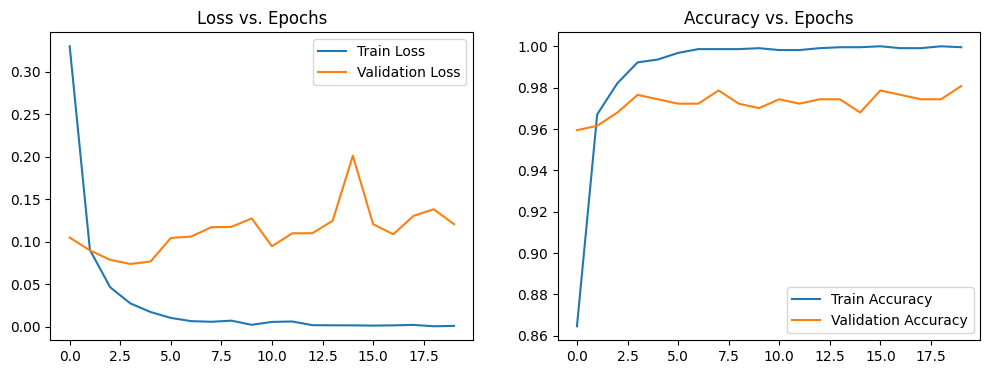

Accuracy on the test dataset: 0.9936


In [ ]:
# Instantiate the simple model
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model = train_model(model, dataloaders, criterion, optimizer)
torch.save(best_model.state_dict(), 'best_model.pth')


Transfer Learning (ResNet18) Training

In [ ]:
# Instantiate the transfer model
transfer_model = create_transfer_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

best_transfer_model = train_model(transfer_model, dataloaders_transfer, criterion, optimizer)
torch.save(best_transfer_model.state_dict(), 'best_transfer_model.pth')


# 4. Demographic Parity and Equal Opportunity Calculations:

Demographic Parity: It measures whether the decision outcome (e.g., getting classified as class 1) is independent of the protected attribute (e.g., gender).

P(decision=1∣gender=male) = P(decision=1∣gender=female)

Equal Opportunity: It measures whether the true positive rate is the same across different values of the protected attribute.

P(decision=1∣label=1,gender=male) = P(decision=1∣label=1,gender=female)

smaller values for both metrics indicate more fairness, with 0 being perfectly fair.

In [ ]:
def compute_demographic_parity(predictions, protected_attributes):
    group_0 = predictions[protected_attributes == 0]
    group_1 = predictions[protected_attributes == 1]

    if len(group_0) == 0 or len(group_1) == 0:
        return np.nan

    return abs(group_0.mean() - group_1.mean())

def compute_equal_opportunity(predictions, labels, protected_attributes):
    group_0 = predictions[(labels == 1) & (protected_attributes == 0)]
    group_1 = predictions[(labels == 1) & (protected_attributes == 1)]

    if len(group_0) == 0 or len(group_1) == 0:
        return np.nan

    return abs(group_0.mean() - group_1.mean())

def evaluate_fairness(model, dataloader, device):
    model.eval()

    all_predictions = []
    all_labels = []
    all_genders = []

    with torch.no_grad():
        for inputs, metadata, labels in dataloader:
            inputs = inputs.to(device)

            # Convert gender data from string to numerical on-the-fly
            genders_numerical = [0 if gender == 'M' else 1 for gender in metadata[0]]
            all_genders.extend(genders_numerical)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_genders = np.array(all_genders)

    print("Number of samples with protected attribute = Male:", sum(all_genders == 0))
    print("Number of samples with protected attribute = Female:", sum(all_genders == 1))
    print("Number of positive predictions with protected attribute = Male:", sum((all_predictions == 1) & (all_genders == 0)))
    print("Number of positive predictions with protected attribute = Female:", sum((all_predictions == 1) & (all_genders == 1)))

    demo_parity = compute_demographic_parity(all_predictions, all_genders)
    equal_opp = compute_equal_opportunity(all_predictions, all_labels, all_genders)

    return demo_parity, equal_opp

# Use the function
demo_parity, equal_opp = evaluate_fairness(best_model, dataloaders['test'], device)
print(f"Demographic Parity: {demo_parity:.4f}")
print(f"Equal Opportunity: {equal_opp:.4f}")

# Use the function
demo_parity_transfer, equal_opp_transfer = evaluate_fairness(best_transfer_model, dataloaders_transfer['test'], device)
print(f"Demographic Parity With ResNet18: {demo_parity_transfer:.4f}")
print(f"Equal Opportunity With ResNet18: {equal_opp_transfer:.4f}")


# **Load Best Model for Evaluation **

In [ ]:
model = SimpleCNN()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set the model to evaluation mode

model = create_transfer_model()
model.load_state_dict(torch.load('best_transfer_model.pth'))
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **Live Processing**

<IPython.core.display.Javascript object>

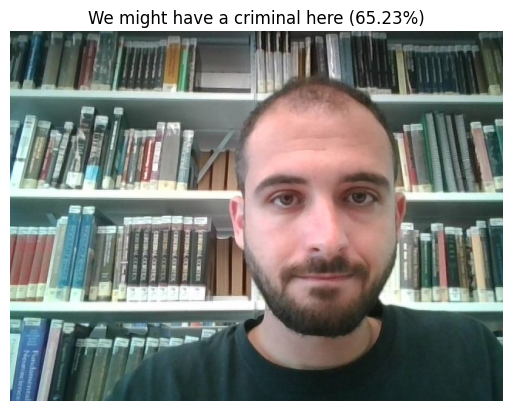

In [20]:
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from tqdm.notebook import tqdm
import cv2

# Simple Custom CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # single channel for grayscale
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # After three pooling layers of stride 2, the image dimensions will be reduced to 200/2/2/2 = 25
        self.fc1 = nn.Linear(64 * 25 * 25, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 25 * 25)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the model
model = SimpleCNN()

# Check if GPU is available and load the model weights accordingly
if torch.cuda.is_available():
    model.load_state_dict(torch.load('best_model.pth'))
else:
    model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))

# Move the model to the appropriate device
model.to(device)
model.eval()  # Set the model to evaluation mode


def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def preprocess_webcam_image(img_path):
    # Read the image using OpenCV
    img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)

    # Convert the image array to grayscale for contour detection
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

    # Find contours
    edges = cv2.Canny(gray, 50, 150)

    # Convert edges back to a grayscale PIL Image for further processing
    contour_image = Image.fromarray(edges).convert('L')

    # Apply the transformations we used for training
    transform = transforms.Compose([
        transforms.Resize((200, 200)),
        transforms.ToTensor()
    ])

    return transform(contour_image).unsqueeze(0)

def live_processing(model, device):
    try:
        # Capture the photo
        filename = take_photo()

        # Preprocess the image
        input_tensor = preprocess_webcam_image(filename)

        # Ensure the tensor is on the same device as the model
        input_tensor = input_tensor.to(device)

        # Get the model's prediction
        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.nn.functional.softmax(output, dim=1)
            predicted_prob, _ = torch.max(prob, 1)

        # Read the original image for display
        img_display = cv2.imread(filename)
        img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

        # Prepare the text label
        if predicted_prob.item() > 0.5:
            text = "We might have a criminal here ({:.2f}%)".format(predicted_prob.item() * 100)
        else:
            text = "Safe to society ({:.2f}%)".format((1 - predicted_prob.item()) * 100)

        # Display the image with the result
        plt.imshow(img_display)
        plt.title(text)
        plt.axis('off')
        plt.show()

    except Exception as e:
        return str(e)

# Use the live_processing function
live_processing(model, device)
